In [1]:
import laspy as lp
import numpy as np

import pyvista as pv 
import pyransac3d as pyrsc

In [2]:
def read_las_file(las_path: str):
    try:
        return lp.read(las_path)
    except Exception as e:
        print(f"Error reading {las_path}: {e}")
        return None

def normalize_points(points, eps= 1e-8):
    if not isinstance(points, np.ndarray) or points.shape[1] != 3:
        raise ValueError("points must be a numpy array with shape (n, 3).")
    points_ = points.copy()

    x_min, x_max = np.min(points_[:,0]), np.max(points_[:,0])
    y_min, y_max = np.min(points_[:,1]), np.max(points_[:,1])
    z_min, z_max = np.min(points_[:,2]), np.max(points_[:,2])

    points_[:,0] = (points_[:,0] - x_min) / (x_max - x_min + eps)
    points_[:,1] = (points_[:,1] - y_min) / (y_max - y_min + eps)
    points_[:,2] = (points_[:,2] - z_min) / (z_max - z_min + eps)
    
    return points_, x_min, x_max, y_min, y_max, z_min, z_max  
   
def normalize_colors(colors):
    rgba = colors - colors.min(axis=0)
    rgba = rgba / rgba.max(axis=0)
    return rgba #(rgba * 255).astype(np.uint8)

def get_points_and_colors_from_las(las_path: str, limit: int = -1):
    if not isinstance(las_path, str):
        raise ValueError("las_path must be a string.")
    if not isinstance(limit, int) or limit < -1:
        raise ValueError("limit must be an integer greater than or equal to -1.")

    las = read_las_file(las_path)
    if las is None:
        raise ValueError("No valid LAS file found.")

    points = np.vstack((las.x, las.y, las.z)).transpose()
    colors = np.vstack((las.red, las.green, las.blue)).transpose()

    if limit > 0:
        idxs = np.random.choice(len(points), limit, replace=False)
        points = points[idxs]
        colors = colors[idxs]

    rgba_colors = normalize_colors(colors)
    return points, colors, rgba_colors, np.expand_dims(las.classification, -1)

In [4]:
import glob
main_path = '/home/diego/Downloads/250111_Pools_100kHz_120m/*.las'
paths = sorted(glob.glob(main_path))
paths

['/home/diego/Downloads/250111_Pools_100kHz_120m/1B_clasificada_col_0_row_0_19s.las',
 '/home/diego/Downloads/250111_Pools_100kHz_120m/2B_clasificada_col_0_row_0_19s.las',
 '/home/diego/Downloads/250111_Pools_100kHz_120m/RBN_clasificada_col_0_row_0_19s.las',
 '/home/diego/Downloads/250111_Pools_100kHz_120m/RBS_clasificada_col_0_row_0_19s.las']

In [48]:
#POOL_NAME = 'RBN'
PROJECT_NAME = '250111_Pools_100kHz_120m'
PATH_PROJECT_LAS = paths[3]#f'data/{PROJECT_NAME}/{POOL_NAME}_clasificada_col_0_row_0_19s.las'
LIMIT = -1

In [49]:
las_points, las_colors, las_rgba_colors, las_clasification = get_points_and_colors_from_las(PATH_PROJECT_LAS, limit=LIMIT)
las_points_norm, x_min, x_max, y_min, y_max, z_min, z_max = normalize_points(las_points[:,:3])

las_data_points = np.hstack((las_points_norm, las_rgba_colors, las_clasification))

other_points = las_data_points[las_data_points[:,-1] != 65]
water_points = las_data_points[las_data_points[:,-1] == 65]

media_of_water_points = np.mean(water_points[:,2], axis=0)

delta = 0.01
X = other_points[:, 0]
Y = other_points[:, 1]
Z = other_points[:, 2]

distances = Z - media_of_water_points

# # Crear un plotter de PyVista
plotter = pv.Plotter()

# Separar los puntos por encima y por debajo del plano
below_plane = distances < -delta
above_plane = distances >= delta
print(below_plane.shape, above_plane.shape)

water_points_pv = pv.PolyData(water_points[:,:3])
plotter.add_points(water_points_pv, color='yellow', point_size=5)

# Añadir los puntos por debajo del plano en verde
points_below = np.column_stack((X[below_plane], Y[below_plane], Z[below_plane]))
points_below_pv = pv.PolyData(points_below)
plotter.add_points(points_below_pv, color='green', point_size=5)

# Añadir los puntos por encima del plano en rojo
points_above = np.column_stack((X[above_plane], Y[above_plane], Z[above_plane]))
points_above_pv = pv.PolyData(points_above)
plotter.add_points(points_above_pv, color='red', point_size=5)

# Mostrar el plotter
plotter.show()

(1133520,) (1133520,)


Widget(value='<iframe src="http://localhost:40893/index.html?ui=P_0x713dd55e4830_19&reconnect=auto" class="pyv…

In [50]:
import matplotlib.pyplot as plt


p99 = np.percentile(water_points[:,2], 99)
z_below = points_below[:,2] 
z = (p99 - z_below) * (z_max - z_min)

np.mean(z)


np.float64(0.8125201260596107)

In [56]:
def bresenham_line(start=(10, 10), end=(10, 60)):
    """
    Generate a list of points using Bresenham's Line Algorithm.

    This algorithm computes the points between two coordinates (start, end),
    producing a list of tuples representing the line connecting these two points
    based on the principle of rasterizing a line.

    Parameters:
        start (tuple): The starting point of the line as (x1, y1).
        end (tuple): The ending point of the line as (x2, y2).

    Returns:
        list: A list of points (x, y) between the start and end points.

    Examples:
        >>> points1 = generate_bresenham_line((0, 0), (3, 4))
        >>> points2 = generate_bresenham_line((3, 4), (0, 0))
        >>> assert(set(points1) == set(points2))
        >>> print(points1)
        [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
        >>> print(points2)
        [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """

    # Unpack start and end points
    x1, y1 = np.array(start, dtype=np.int32).copy()
    x2, y2 = np.array(end, dtype=np.int32).copy()


    # Calculate differences
    dx = x2 - x1
    dy = y2 - y1

    # Determine if the line is steep (more vertical than horizontal)
    is_steep = abs(dy) > abs(dx)

    # Swap coordinates if the line is steep (for easier handling)
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Ensure the line is always drawn left-to-right
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1

    # Recalculate differences after the possible swap
    dx = x2 - x1
    dy = y2 - y1

    # Error term initialized to half of dx
    error = dx // 2
    ystep = 1 if y1 < y2 else -1  # Determines whether to increment or decrement y

    # List to store the generated points
    points = []
    y = y1

    # Main loop for Bresenham's algorithm
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)  # Swap x and y if the line is steep
        points.append(coord)

        # Update error term
        error -= abs(dy)

        # If error is negative, adjust y and reset the error term
        if error < 0:
            y += ystep
            error += dx

    return np.array(points)


Mean Height Difference (All REAL Points): 0.81 m
Mean Height Difference (Diagonal 1): -0.74 m
Mean Height Difference (Diagonal 2): -0.74 m
Mean Height Difference (All Points): 0.71 m


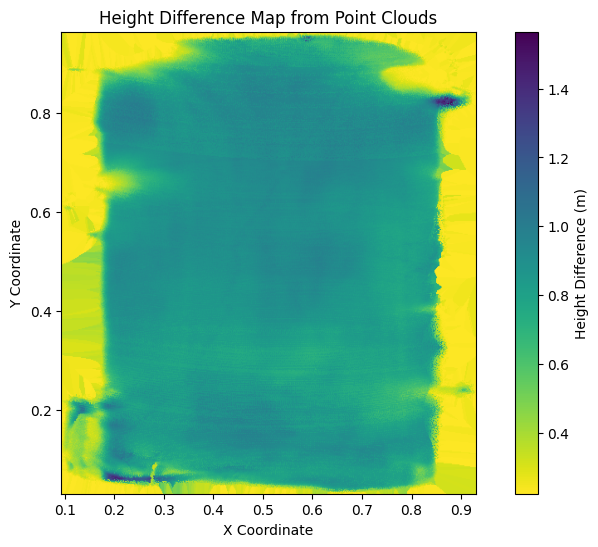

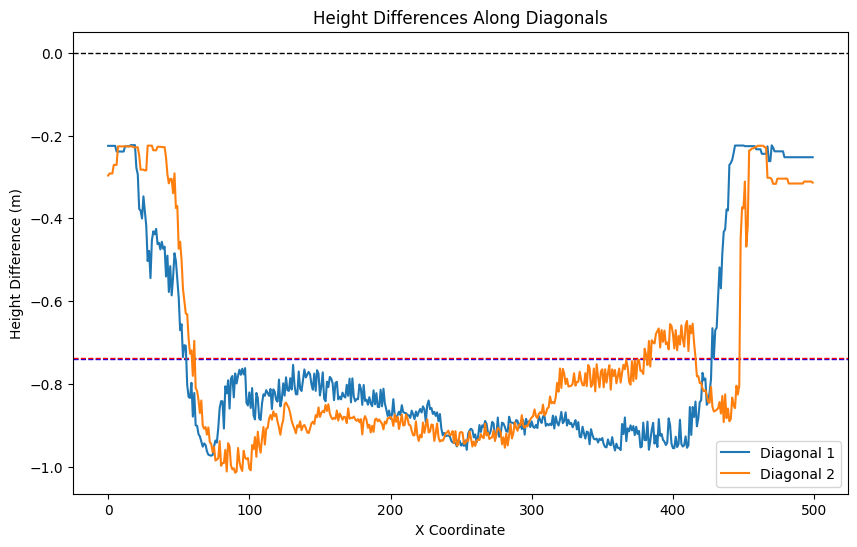

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata

h1 = points_below_pv
h0 = water_points_pv

# Assume h0 and h1 are both PyVista point clouds
x0, y0, z0 = h0.points[:, 0], h0.points[:, 1], h0.points[:, 2]
x1, y1, z1 = h1.points[:, 0], h1.points[:, 1], h1.points[:, 2]

# Step 5: Interpolate onto a regular grid for DEM visualization
grid_res = 500 # Adjust resolution
x_min, x_max = x1.min(), x1.max()
y_min, y_max = y1.min(), y1.max()

grid_x, grid_y = np.meshgrid(
    np.linspace(x_min, x_max, grid_res),
    np.linspace(y_min, y_max, grid_res)
)

grid_z = griddata((x1, y1), z, (grid_x, grid_y), method="nearest")

# Step 7: Calculate height differences along diagonals
diagonal_gap = 5  # Gap between points along the diagonals

# Diagonal 1: Top-left to bottom-right
top_left = (0,0)
bottom_right = (grid_res-1, grid_res-1)
diagonal1 = bresenham_line(top_left, bottom_right)
diagonal1_z = [grid_z[y, x]*-1 for x, y in diagonal1]
mean_diagonal1 = np.mean(diagonal1_z)

# Diagonal 2: Top-right to bottom-left
top_right = (grid_res-1, 0)
bottom_left = (0, grid_res-1)
diagonal2 = bresenham_line(bottom_left, top_right)
diagonal2_z = [grid_z[y, x] *-1 for x, y in diagonal2]
mean_diagonal2 = np.mean(diagonal2_z)

print(f"Mean Height Difference (All REAL Points): {np.mean(z):.2f} m")
print(f"Mean Height Difference (Diagonal 1): {mean_diagonal1:.2f} m")
print(f"Mean Height Difference (Diagonal 2): {mean_diagonal2:.2f} m")
print(f"Mean Height Difference (All Points): {np.mean(grid_z):.2f} m")

# Step 6: Plot the height difference map
plt.figure(figsize=(10, 6))
plt.imshow(grid_z, extent=(x_min, x_max, y_min, y_max), origin="lower", cmap="viridis_r")
plt.colorbar(label="Height Difference (m)")
plt.title("Height Difference Map from Point Clouds")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

# Plot diagonal height differences
plt.figure(figsize=(10, 6))
# horizontal line in 0
plt.axhline(0, color='black', linestyle='--', linewidth=1)
# horizontal line in mean diagonal 1
plt.axhline(mean_diagonal1, color='blue', linestyle='--', linewidth=1)
# horizontal line in mean diagonal 2
plt.axhline(mean_diagonal2, color='red', linestyle='--', linewidth=1)
plt.plot(diagonal1_z, label='Diagonal 1')
plt.plot(diagonal2_z, label='Diagonal 2')
plt.xlabel('X Coordinate')
plt.ylabel('Height Difference (m)')
plt.title('Height Differences Along Diagonals')
plt.legend()
plt.show()

In [61]:
bresenham_line((0,0), (10,10))

array([[ 0,  0],
       [ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10]])

In [84]:
import cv2
import os
from PIL import Image

os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

z_save = grid_z.astype(np.float32) 
cv2.imwrite(f'z_model2.exr', z_save)

pil_image_z = Image.fromarray(z_save)
pil_image_z.save(f'z_model2.tiff')



